In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from somefunc import *
%load_ext autoreload
%autoreload 2

images_path = "data/images"

In [2]:
df = pd.read_csv('data/cleaned_by_etienne.csv')
df["product_category_tree"] = df["product_category_tree"].apply(clean_categ)
df['path_file'] = df["uniq_id"].apply(get_path_file)
df['categ_0'] = df["product_category_tree"].apply(get_subcateg, deepness = 0)
df['categ_1'] = df["product_category_tree"].apply(get_subcateg, deepness = 1)
df['categ_2'] = df["product_category_tree"].apply(get_subcateg, deepness = 2)
# df['categ_3'] = df["product_category_tree"].apply(get_subcateg, deepness = 3)

df['description'] = df['description'].apply(preprocess_text)

df.drop(columns=['crawl_timestamp','product_url','pid', 'retail_price', 'discounted_price',
'image','is_FK_Advantage_product','product_rating','overall_rating','brand','product_specifications','uniq_id'],inplace=True)

lala
lala
lala


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(df['description'].values).batch(128)
vectorizer.adapt(text_ds)
vectorizer.get_vocabulary()[:40]
# si besoin de passer des stopwords il faudra les enlever de voc
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [4]:
path_to_glove_file = "./glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [5]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 4844 words (1831 misses)


In [6]:
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,)

<AxesSubplot:>

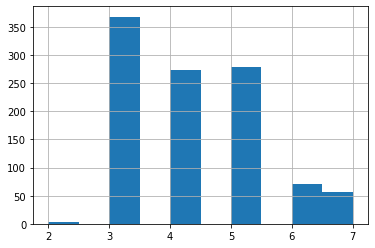

In [5]:
df['categ_list'] = df["product_category_tree"].apply(get_subcateg)
df['categ_list'].apply(len).hist()

In [7]:
descriptions_list = df['description'].values
descriptions_list = vectorizer(descriptions_list).numpy()

images_list = get_img_list(df.path_file.values)
categ_0_list_num, categ_0_names= pd.factorize(df['categ_0'])
categ_0_list_hot =  tf.keras.utils.to_categorical(categ_0_list_num, num_classes=len(categ_0_names))

categ_1_list_num, categ_1_names= pd.factorize(df['categ_1'])
categ_1_list_hot =  tf.keras.utils.to_categorical(categ_1_list_num, num_classes=len(categ_1_names))

In [8]:
from sklearn.model_selection import train_test_split
X_train_img, X_val_img, y_train_0, y_val_0 = train_test_split(images_list, categ_0_list_hot, test_size=0.1, random_state=42)
X_train_text, X_val_text, y_train_1, y_val_1 = train_test_split(descriptions_list, categ_1_list_hot, test_size=0.1, random_state=42)

Baby Care
Baby Bath & Skin


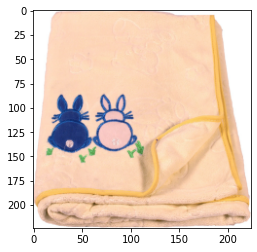

In [24]:
import numpy as np
num = 9
lala =  np.argmax(y_train_0[num])
print(categ_0_names[lala])
lulu =  np.argmax(y_train_1[num])
print(categ_1_names[lulu])
plt.imshow(X_train[num])

In [30]:
# ds = tf.data.Dataset.from_tensor_slices((images_list, categ_0_list_hot))
ds_train_X = tf.data.Dataset.from_tensor_slices((X_train_img, X_train_text))
ds_train_y = tf.data.Dataset.from_tensor_slices((y_train_0, y_train_1))

ds_train = tf.data.Dataset.zip((ds_train_X, ds_train_y))

ds_val_X = tf.data.Dataset.from_tensor_slices((X_val_img, X_val_text))
ds_val_y = tf.data.Dataset.from_tensor_slices((y_val_0, y_val_1))
ds_val = tf.data.Dataset.zip((ds_val_X, ds_val_y))

In [32]:
BATCH_SIZE=16
ds_train = ds_train.shuffle(buffer_size=64).batch(BATCH_SIZE)
# .prefetch( tf.data.AUTOTUNE)
ds_val  = ds_val.shuffle(buffer_size=64).batch(BATCH_SIZE)

In [13]:
next(iter(ds_train))

((<tf.Tensor: shape=(16, 224, 224, 3), dtype=uint8, numpy=
  array([[[[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
  
          [[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
  
          [[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
  
          ...,
  
          [[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
  
          [[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255

In [ ]:
image_batch,label_batch = next(iter(ds_train))
label_batch

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model

model_text_in = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(model_text_in)
x_text = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x_text = layers.MaxPooling1D(5)(x_text)
x_text = layers.Conv1D(128, 5, activation="relu")(x_text)
x_text = layers.MaxPooling1D(5)(x_text)
x_text = layers.Conv1D(128, 5, activation="relu")(x_text)
x_text = layers.GlobalMaxPooling1D()(x_text)
x_text = layers.Dense(128, activation="relu")(x_text)
out_text = layers.Dropout(0.5)(x_text)

IMG_SIZE = 224
base_model = EfficientNetB0(include_top=True, weights="imagenet")
base_model = Model(base_model.inputs, base_model.layers[-2].output)
base_model.trainable=False

model_img_in = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
out_img = base_model(model_img_in)

out_features = layers.Concatenate()([out_text , out_img])

#Stage to predict level 0 category
manager_cat_0 = layers.Dense(128,activation='relu')(out_features)
model_out_cat_0 = layers.Dense(7,activation='softmax', name='out_cat_0')(manager_cat_0)

#Stage to predict level 1 category
manager_cat_1 = layers.Dense(128,activation='relu')(out_features)
mixer_cat_1 = layers.Concatenate()([manager_cat_0, manager_cat_1])
# mixer_cat_1 = layers.Concatenate()([model_out_cat_0, manager_cat_1])
post_mixer_cat_1 = layers.Dense(128,activation='relu')(mixer_cat_1)
model_out_cat_1 = layers.Dense(62,activation='softmax', name='out_cat_1')(post_mixer_cat_1)


model_effnet = tf.keras.Model(inputs=[model_img_in, model_text_in], outputs=[model_out_cat_0, model_out_cat_1])

In [15]:
model_effnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    667700      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, None, 128)    64128       ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, None, 128)    0           ['conv1d[0][0]']                 
                                                                                            

In [ ]:
# tf.keras.layers.Concatenate()([x1, x2])

In [16]:
model_effnet.compile(optimizer="adam", loss=["categorical_crossentropy","categorical_crossentropy"],loss_weights=[0.6, 0.4], metrics=["accuracy"])
# model_test.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# es = EarlyStopping(mode='min', monitor='val_loss', patience=10, verbose=0)
rl = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4,verbose=1,mode="min",min_lr=0.00001)

In [17]:
history = model_effnet.fit(ds_train,
                            epochs = 25,
                            validation_data=ds_val,
                            # sample_weight={'out_cat_0': 0.6, 'out_cat_1': 0.4}
                            # callbacks=[rl]
                            # steps_per_epoch=50,
                            # validation_steps = 5
                            )

Epoch 1/25
60/60 [==============================] - 8s 44ms/step - loss: 1.4343 - out_cat_0_loss: 0.8021 - out_cat_1_loss: 2.3826 - out_cat_0_accuracy: 0.7513 - out_cat_1_accuracy: 0.4794 - val_loss: 0.8953 - val_out_cat_0_loss: 0.3724 - val_out_cat_1_loss: 1.6797 - val_out_cat_0_accuracy: 0.8857 - val_out_cat_1_accuracy: 0.6000
Epoch 2/25
60/60 [==============================] - 2s 26ms/step - loss: 0.6318 - out_cat_0_loss: 0.3228 - out_cat_1_loss: 1.0952 - out_cat_0_accuracy: 0.8984 - out_cat_1_accuracy: 0.7344 - val_loss: 0.7583 - val_out_cat_0_loss: 0.3245 - val_out_cat_1_loss: 1.4091 - val_out_cat_0_accuracy: 0.9048 - val_out_cat_1_accuracy: 0.7143
Epoch 3/25
60/60 [==============================] - 2s 25ms/step - loss: 0.3625 - out_cat_0_loss: 0.1987 - out_cat_1_loss: 0.6081 - out_cat_0_accuracy: 0.9376 - out_cat_1_accuracy: 0.8455 - val_loss: 0.7047 - val_out_cat_0_loss: 0.2909 - val_out_cat_1_loss: 1.3254 - val_out_cat_0_accuracy: 0.9238 - val_out_cat_1_accuracy: 0.7048
Epoch 4

In [58]:
model_effnet.trainable = True
history = model_effnet.fit(ds_train,
                            epochs = 25,
                            validation_data=ds_val,
                            # sample_weight={'out_cat_0': 0.6, 'out_cat_1': 0.4}
                            # callbacks=[rl]
                            # steps_per_epoch=50,
                            # validation_steps = 5
                            )

Epoch 1/25
60/60 [==============================] - 2s 24ms/step - loss: 0.0023 - out_cat_0_loss: 0.0016 - out_cat_1_loss: 0.0033 - out_cat_0_accuracy: 1.0000 - out_cat_1_accuracy: 0.9989 - val_loss: 1.1237 - val_out_cat_0_loss: 0.3869 - val_out_cat_1_loss: 2.2290 - val_out_cat_0_accuracy: 0.8762 - val_out_cat_1_accuracy: 0.7048
Epoch 2/25
60/60 [==============================] - 1s 22ms/step - loss: 0.0014 - out_cat_0_loss: 0.0011 - out_cat_1_loss: 0.0019 - out_cat_0_accuracy: 1.0000 - out_cat_1_accuracy: 1.0000 - val_loss: 1.1001 - val_out_cat_0_loss: 0.3814 - val_out_cat_1_loss: 2.1783 - val_out_cat_0_accuracy: 0.8762 - val_out_cat_1_accuracy: 0.7143
Epoch 3/25
60/60 [==============================] - 1s 22ms/step - loss: 0.0025 - out_cat_0_loss: 0.0032 - out_cat_1_loss: 0.0015 - out_cat_0_accuracy: 0.9989 - out_cat_1_accuracy: 1.0000 - val_loss: 1.1444 - val_out_cat_0_loss: 0.4048 - val_out_cat_1_loss: 2.2539 - val_out_cat_0_accuracy: 0.8857 - val_out_cat_1_accuracy: 0.7143
Epoch 4

In [57]:
tf.keras.layers.LayerNormalization()(toto)

<tf.Tensor: shape=(1280,), dtype=float32, numpy=
array([ 0.9934341 , -0.54822373, -0.50203156, ...,  0.38839385,
        1.302862  , -0.6654497 ], dtype=float32)>

In [36]:
model_effnet.save('models/ model_effnet_2in&2out.h5')

In [41]:
X_batch, y_batch = next(iter(ds_val))
image_batch = X_batch[0]
results = model_effnet.predict(X_batch)

1/1 [==============================] - 0s 16ms/step


Beauty and Personal Care
Fragrances


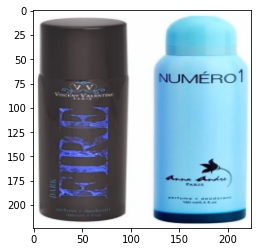

In [42]:
import numpy as np
num = 7
lala0 =  np.argmax(results[0][num])
lala1 =  np.argmax(results[1][num])

print(categ_0_names[lala0])
print(categ_1_names[lala1])

plt.imshow(image_batch[num])